# TQV lakes in WEIO tracking code
### suitable for running as .py (time loops is in one cell) 

#Backward time loop to track coast-crossing vapor lakes (CCVLs) using Geopandas methods from Geopandas_overlaps.ipynb, filename=tag format is `yyyymmddhh.meanlat.55` where meanlat is the mean latitude of the overlap with a coastline and 55 is the contour level. Some key strings: "dest" means "destined to happen", that is the prior timestep in a backward loop. "now" means the present time in that loop. "gdf_" leads off GeoDataFrames. "CCVL" is a coast-crossing vapor lake, the high-level (across-time) entity we are tracking here. 

In [55]:
!date

Mon Jun 14 14:16:41 MDT 2021


# Key parameters up top 

In [218]:
data_dir = './MERRA2_tqv_201406/'
tqv_conlevel = 55. # mm

### Package imports

In [219]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import os         
from glob import glob
import xarray as xr

from shapely import geometry
import pandas as pd
import geopandas as gp

from datetime import datetime

# Define key functions

In [220]:
# A function to return a GeoDataFrame of polygons
# by looping over contour collections (and polygons in each collection) 
# and creating a list of shapes called polylist  

MAXLONLIMIT = 89 # degrees east, the Megalake 
SMALLSIZELIMIT = 1    # square degree 

def gdf_from_contours(lon,lat,tqv,conlevel):
    '''Inputs: lon, lat, tqv(lon,lat), contour level'''    

    levels = [conlevel, 9e9] # infinitely large number as second level
    cs = plt.contourf(lon,lat,tqv,levels) # filled contours return the right kind of cs
    
# create lookup table for levels, not needed for single contour level but keep it
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []  # zvalues, in case one wants polygons for multiple levels

    for col in cs.collections:
        z=lvl_lookup[col] # the value of this level
        for contour_path in col.get_paths():
        # create the polygon for this level
            for ncp,cp in enumerate(contour_path.to_polygons()):
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
            
# The magic: make a GeoPandas frame, and a few attribute columns 
        gdf = gp.GeoDataFrame(geometry=polylist)
        gdf['tqv_values']=zvalues
        gdf['area']=gdf.area
        gdf['maxlon']=gdf.bounds.maxx
        
# Only keep ones that aren't megalake (maxlon < 89), and small ones
        gdf = gdf[gdf.maxlon <MAXLONLIMIT]
        gdf = gdf[gdf.area   >SMALLSIZELIMIT]

        # re-index 
        num_now = len(gdf.index)
        gdf.index = range( num_now )

        return(gdf)

In [221]:
files = glob(data_dir+'MERRA2_400.inst1_2d_asm_Nx.2014060[1,2].SUB.nc')
files

['./MERRA2_tqv_201406/MERRA2_400.inst1_2d_asm_Nx.20140602.SUB.nc',
 './MERRA2_tqv_201406/MERRA2_400.inst1_2d_asm_Nx.20140601.SUB.nc']

# Initiate some needed objects: 
#### Contours of coastal (or littoral) east Africa in 20N-S
#### Some empty arrays defined before the loop uses them

time level:  2014-06-02T23:00:00.000000000
creating gdf_ccvls:  ccvl_2014_06_02_23_lat3p549S = gdf_ccvls.iloc[0:1]
creating gdf_ccvls:  ccvl_2014_06_02_23_lat7p513N = gdf_ccvls.iloc[1:2]


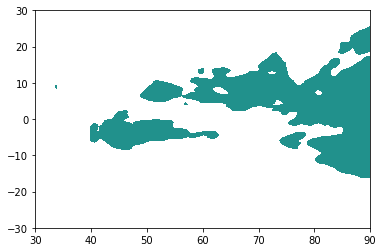

In [222]:
# The littoral contours 
gdf_litt = gp.read_file('Africa_Ecoast_20NS.geojson')
#gdf_litt.plot()

ccvls_stats = [] # empty, to collect the stats of ccvls

# Open the virtual (time series) dataset in xarray
# MERRA2_400.inst1_2d_asm_Nx.20140601.SUB.nc

files = glob(data_dir+'MERRA2_400.inst1_2d_asm_Nx.2014060[1,2].SUB.nc')
             #+glob('*2015*')+glob('*2016*')
cwv_data = xr.open_mfdataset(files) # merging data files in one

# Subset data to the WEIO (30-90E, 30S-30N)
cwv_WEIO = cwv_data.sel(lat=slice(-30,30),lon=slice(30,90))

# To initialize before looping, process the last-most time (index -1) to a gdf
gdf_dest = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.TQV[-1],tqv_conlevel)

# Find coast-overlappers, using query_bulk which returns index arrays
i_litt, i_dest = gdf_dest.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 
# i_litt values lie in 0,3 since there are 4 polygons in the littoral gdf

# gdf_ccvls is a SUBSET: I only care about ones that touch the coast
gdf_ccvls = gdf_dest.loc[i_dest].drop_duplicates()
# Must re-index in order for .loc[] to work later in overlap tests 
gdf_ccvls.index = range( len(gdf_ccvls.index) )

# A GeoDataFrame is 1 column with shapes, plus additional columns of attributes.
# Add data columns: time and tag (`tag` is a string, yyyymmddhh_meanlat)
## tag is useful for constructing filenames

# time (given by xarray) appears to be a datetime64 object
yyyymmddhh = cwv_WEIO.time[-1].values
print('time level: ', yyyymmddhh)
gdf_ccvls['time'] = yyyymmddhh 

# time as a string (parse through pandas, there are DIFFERENT datetimes, UGH!)
timestring = pd.to_datetime(str(yyyymmddhh)).strftime('%Y_%m_%d_%H')

# mean latitude
centlats = gdf_ccvls.geometry.centroid.y

# need tag to be a string with special characters (- nor .) 
# use N/S rather than dash for sign, and p for "point" in meanlat
# carry 5 characters of abs(meanlat), plenty enough to be unique
NS = ['N','S']
ccvltags = [  timestring+'_lat'+ str(abs(centlats[i]))[:5]   for i in range(len(centlats)) ] 
ccvltags = [ ccvltags[i] + NS[ int(centlats[i]<0) ]   for i in range(len(centlats)) ] 
ccvltags = [ ccvltags[i].replace('.','p') for i in range(len(ccvltags)) ]

gdf_ccvls['tag'] = ccvltags

# Initialize a GDF for each CCVL
### so that shapes at other times can be appended within the time loop 

# Clever trick exec(command), that's how tag can be used as a variable name

## HUGE HEADACHE with append()
## I have to subset using two-index range [0:1] to make it work
## actually, transposing may suffice, .to_frame().T, but this works.
## to make this work: ccvl_2014_05_15_23_lat5p382S.append(ccvl_2014_05_15_23_lat5p577S)

for i in range(len(gdf_ccvls)):
    command = 'ccvl_' + gdf_ccvls.iloc[i].tag + ' = gdf_ccvls.iloc[' +str(i)+':'+str(i+1)+']'
    print('creating gdf_ccvls: ', command)
    exec(command) # creates new gdf for each tag, ready to append 
    # example: 
    # ccvl_2014_05_15_23_lat5p382S = gdf_ccvls.iloc[0:1]
    # creating gdf:  ccvl_2014_06_09_07_lat4p676N = gdf_newccvl.to_frame().T

# For restart or continuation, 
### one could read in the needed variables above, 
### rather than starting from the last time in the data

In [223]:
# --- 
# Discussion of backward time loop action steps 
# We need to  

# 1. Check the overlap of *gdf_now* with pre-existing *gdf_ccvl* shapes
# 1. Transfer CCVL tag to any (all) overlaps with maxlon<89E , discarding others
# 1. Append all non-megalake overlappers to a GDF for each CCVL, ready to write out
# 1. Testing for CCVL birth (present in dest, absent in now). 
      # Write terminated CCVLs as .geojson, and append their duration, areatime, bounds 
      # and other stats to a big Pandas df meta-index of all CCVLs
# 1. Find new coast-crossers now, spawn as new CCVLs IFF they don't exist yet
# 1. Transfer gdf_ccvls_now to gdf_ccvls for next iteration


terminate:  2014_06_02_23_lat7p513N.geojson
             lasttime duration   areatime  tqv_values    maxarea  \
0 2014-06-02 23:00:00   0 days  29.266415        55.0  29.266415   

                          filename  
0  2014_06_02_23_lat7p513N.geojson  
adding new ccvl:  2014-06-02T23:00:00.000000000
terminate:  2014_06_02_18_lat5p470N.geojson
             lasttime        duration  areatime  tqv_values  maxarea  \
0 2014-06-02 18:00:00 0 days 02:00:00  3.375382        55.0  1.21432   

                          filename  
0  2014_06_02_18_lat5p470N.geojson  
adding new ccvl:  2014-06-02T23:00:00.000000000
terminate:  2014_06_02_14_lat5p651N.geojson
             lasttime        duration  areatime  tqv_values   maxarea  \
0 2014-06-02 14:00:00 0 days 02:00:00  3.344362        55.0  1.128018   

                          filename  
0  2014_06_02_14_lat5p651N.geojson  
adding new ccvl:  2014-06-02T23:00:00.000000000
terminate:  2014_06_02_05_lat8p351N.geojson
             lasttime        

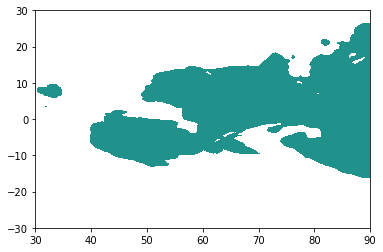

In [224]:
# %debug
# Time loop over hours, backward in time

for i in range( len(cwv_WEIO.time)-1 ):
    iback = -(i+2)
    # print('time level is ', iback) #confirms iback goes -2, -3, -4, ... 

# Step 1 in loop: create gdf_now, and find its overlaps with gdf_ccvls

    gdf_now = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.TQV[iback],tqv_conlevel)
    i_ccvls, i_now = gdf_now[(gdf_now.area>0)].sindex.query_bulk(gdf_ccvls.geometry, predicate='overlaps') 

# Step 2 in loop: copy overlappers into gdf_ccvls_now, copy tag, add time.

    # Assign gdf: gdf_ccvls_now, all 'now' objects that are part of a ccvl
    gdf_ccvls_now = gdf_now.loc[i_now]

    # Port the tags from ccvls to ccvls_now
    gdf_ccvls_now['tag'] = gdf_ccvls.iloc[i_ccvls].tag.values
    gdf_ccvls_now['time'] = cwv_WEIO.time[iback].values
    
    # Must re-index in order for .iloc[] to work later in coast overlap test 
    num_now = len(gdf_ccvls_now.index)
    gdf_ccvls_now.index = range( num_now )
    
    # if( num_now > 20 ): print('num_now is big: ', num_now, gdf_ccvls)

## Step 3 in loop: Append all gdf_ccvl_now rows onto 
## the existing GDFs for each CCVL, to write out as final result files.

    for i in range( num_now ):
        command = 'ccvl_' + gdf_ccvls_now.iloc[i].tag + ' = ' + \
                  'ccvl_' + gdf_ccvls_now.iloc[i].tag + \
                  '.append(gdf_ccvls_now.iloc[' +str(i)+':'+str(i+1)+'])'
        # print('Step 3 appending: ', command)
        exec(command) 
        # Example: 
        # ccvl_2014_06_09_01_lat4p387N = ccvl_2014_06_09_01_lat4p387N
        #                               .append(gdf_ccvls_now.iloc[0:1])

## Step 4: terminate tracking of any `dest` ccvls that don't exist `now`

    orphan_tags = pd.concat( [gdf_ccvls_now.tag, gdf_ccvls.tag] ).drop_duplicates(keep=False)

    for i in range(len(orphan_tags)):
        # WRITE OUT CCVL FILE
        outfilename = str(orphan_tags.iloc[i]) + '.geojson'
        command = 'gp.GeoDataFrame(ccvl_' + str(orphan_tags.iloc[i]) + \
                  ').to_file("' + str(orphan_tags.iloc[i]) + \
                  '.geojson", driver="GeoJSON")'
        print('terminate: ', outfilename)
        exec(command)
        # Example 
        # gp.GeoDataFrame(ccvl_2014_06_09_07_lat4p676N).to_file("2014_06_09_07_lat4p676N.geojson", driver="GeoJSON")


        # GATHER ccvl_stats
        ccvlname = 'ccvl_' + str(orphan_tags.iloc[i])
        command2 = 'dummy = ' + ccvlname + '.copy()'
        exec(command2)

        areatime = dummy['area'].sum()
        maxarea = dummy['area'].max()
        duration = dummy['time'].max() - dummy['time'].min()
        tqv_values = dummy['tqv_values'].mean()
        lasttime = dummy['time'].max()
        ccvl_stats = pd.DataFrame(
            {
             "lasttime": [lasttime],
             "duration": [duration],
             "areatime": [areatime],
             "tqv_values": [tqv_values],
             "maxarea": [maxarea],
             "filename": [outfilename]
            } )
        
        print(ccvl_stats)

        # APPEND ccvl_stats TO ccvls_stats, a growindg index of all CCVLs.
        if(len(ccvls_stats)<1): ccvls_stats = ccvl_stats # first time step
        else: ccvls_stats = ccvls_stats.append(ccvl_stats) # all others

        # DELETE FROM MEMORY in long loops 
        command3 = 'del(ccvl_' + str(orphan_tags.iloc[i]) + ')'
        exec(command3) # example del(ccvl_2014_06_09_07_lat4p676N)
                       
## Step 5: Find NEW ccvl's: coast-crossers now, not in megalake

    i_litt, i_now_cc = gdf_now.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 

    for i in np.unique(i_now_cc):  # because a shape may overlap two littoral segments
        if not (i in i_now): # i_now was the overlap of gdf_ccvls with gdf_now

            gdf_newccvl = gdf_now.iloc[i].copy()
            print('adding new ccvl: ', yyyymmddhh) #gdf_newccvl)

            # add time: uh-oh, is this the same kind of datetime object?? 
            timenow = cwv_WEIO.time[iback].values
            gdf_newccvl['time'] = timenow

            # add tag = timestring + str(meanlat)
            timestring = pd.to_datetime(str(timenow)).strftime('%Y_%m_%d_%H')
            centlat = gdf_newccvl.geometry.centroid.y
            ccvltags = timestring+'_lat'+ str(abs(centlat))[:5]
            ccvltags = ccvltags + NS[ int(centlat<0) ] 
            ccvltags = ccvltags.replace('.','p') 
            gdf_newccvl['tag'] = ccvltags

            # append this new ccvl to ccvls_now
            gdf_ccvls_now = gdf_ccvls_now.append(gdf_newccvl)

            # create the corresponding ccvl_tag... gdf for this new ccvl
            # in transposed form, ready to append onto in next time steps
            command = 'ccvl_' + gdf_newccvl.tag + ' = gdf_newccvl.to_frame().T' 
            exec(command) # creates new gdf
            # example ccvl_2014_06_09_07_lat4p676N = gdf_newccvl.to_frame().T

## Step 6: # re-index, and transfer gdf_ccvls_now to gdf_ccvls for next iteration

    gdf_ccvls = gdf_ccvls_now
    del(gdf_ccvls_now) # empty variable for next time
    
    # re-index 
    gdf_ccvls.index = range( len(gdf_ccvls.index) )

## That was the end of the time loop! 
## Write out ccvls_stats 
ccvls_stats.index = range( len(ccvls_stats) )
print('End of time loop: ', ccvls_stats)
    
## Write out restart files (gdf_ccvls_dest, and the gdf's of all its lakes, ccvl_...)
## and then set up the reading-in code at initiation section 


## Write out any orphans at the last time level: should this be made into a function? 
## Need a unique screening someplace 
orphan_tags = gdf_ccvls.tag.drop_duplicates()
for i in range(len(orphan_tags)):
    # WRITE OUT CCVL FILE
    outfilename = str(orphan_tags.iloc[i]) + '.geojson'
    command = 'gp.GeoDataFrame(ccvl_' + str(orphan_tags.iloc[i]) + \
              ').to_file("' + str(orphan_tags.iloc[i]) + \
              '.geojson", driver="GeoJSON")'
    print('terminate at end of time loop: ', outfilename)
    exec(command)
    # Example 
    # gp.GeoDataFrame(ccvl_2014_06_09_07_lat4p676N).to_file("2014_06_09_07_lat4p676N.geojson", driver="GeoJSON")


    # GATHER ccvl_stats
    ccvlname = 'ccvl_' + str(orphan_tags.iloc[i])
    command2 = 'dummy = ' + ccvlname + '.copy()'
    exec(command2)

    areatime = dummy['area'].sum()
    maxarea = dummy['area'].max()
    duration = dummy['time'].max() - dummy['time'].min()
    tqv_values = dummy['tqv_values'].mean()
    lasttime = dummy['time'].max()
    ccvl_stats = pd.DataFrame(
        {
         "lasttime": [lasttime],
         "duration": [duration],
         "areatime": [areatime],
         "tqv_values": [tqv_values],
         "maxarea": [maxarea],
         "filename": [outfilename]
        } )

    print(ccvl_stats.drop_duplicates())

    # APPEND ccvl_stats TO ccvls_stats, a growindg index of all CCVLs.
    if(len(ccvls_stats)<1): ccvls_stats = ccvl_stats # first time step
    else: ccvls_stats = ccvls_stats.append(ccvl_stats) # all others


In [225]:
def showme(filename):   # like '2014_05_15_02_lat9p247N.geojson'
    gdf = gp.read_file(filename)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(30, 93)
    ax.set_ylim(-20,20)
    ax.set_title(filename)

    gdf.plot(ax=ax, edgecolor='black', alpha=0.3)
    #gdf.boundary.plot(ax=ax, color='red')
    path = gp.datasets.get_path('naturalearth_lowres')
    mapdf = gp.read_file(path)
    mapdf.boundary.plot(ax=ax)
    # print(gdf)

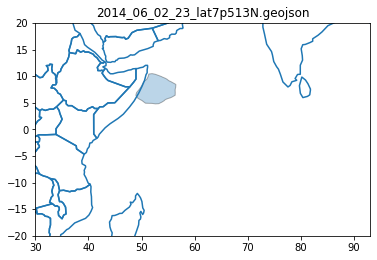

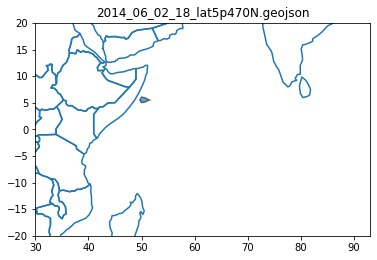

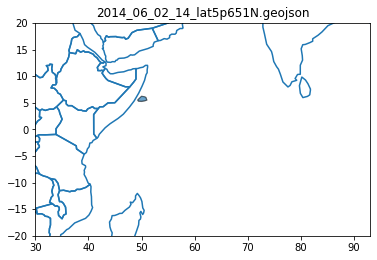

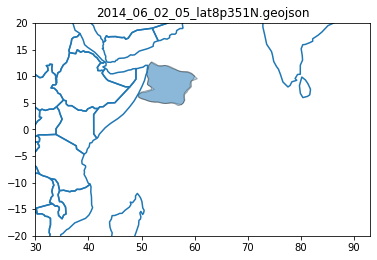

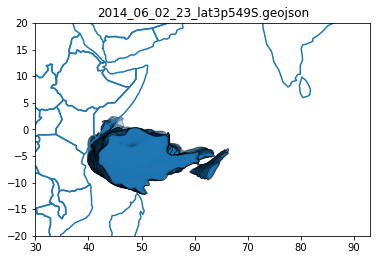

In [226]:
for file in ccvls_stats.filename: 
    showme(file)

In [227]:
ccvls_stats

,lasttime,duration,areatime,tqv_values,maxarea,filename
0,2014-06-02 23:00:00,0 days 00:00:00,29.266415,55.0,29.266415,2014_06_02_23_lat7p513N.geojson
1,2014-06-02 18:00:00,0 days 02:00:00,3.375382,55.0,1.214320,2014_06_02_18_lat5p470N.geojson
2,2014-06-02 14:00:00,0 days 02:00:00,3.344362,55.0,1.128018,2014_06_02_14_lat5p651N.geojson
3,2014-06-02 05:00:00,0 days 01:00:00,106.360632,55.0,53.475755,2014_06_02_05_lat8p351N.geojson
0,2014-06-02 23:00:00,1 days 23:00:00,10867.678687,55.0,128.754892,2014_06_02_23_lat3p549S.geojson
